# Homework 3

### Due Date: Tuesday, October 30, 2018

### Getting Started

- Training optimal policies / value functions can take very long, so be sure to start solving the problems early to give yourself enough time to finish training everything.
- Please save any plots you generate and add them to the notebook. We will not rerun your code for you.

# Question 1: Direct Policy Algorithms

While in previous assignments we focused primarily on value iteration algorithms (e.g. DQN), in this homework we will be implementing direct policy algorithms, which simply learn the parameters of your mapping from states to actions. The structure of these algorithms are essentially the same as those we implemented previously, with the core constituents being a function approximator, a method for computing actions, a method for collecting samples, and a training operation. Accordingly, in order to recycle aspects of the code, we choose to organize these methods into a parent class which may then be abstracted and recycled for the algorithms we implement in subsequent problems.

In the below cell, we have instantiated this class and filled in the components you have already written up in homework 2. Spend some time reviewing this class, and then complete the following missing operations:

1. Modify the `create_model` method to output a trainable variable (i.e. `tf.get_variable`) that computes the logstd of a certain action in the case of stochastic policies. For this assignment, we will assume that this variable is not dependent on the input state. We will use this in problems 2 and 3.
2. Modify in the `action_op` method to calculate and return the actions based on the current parametrization of the policy in the stochastic setting (mean, logstd). The action should be: $\pi(s) = \pi_\text{mean}(s) + exp(logstd) * \mathcal{N}(0,1)$.
3. Test your implemenations in the cells immediately below this class! This should help you do this incrementally.

**Hints**: 

- Refer to the `__init__` method when choosing the placeholders and dimensions for your augmentations to the above methods. 
- Some useful tensorflow classes and methods include: `tf.get_variable`, `tf.exp`, `tf.random_normal`.

In [1]:
import tensorflow as tf
import tensorflow.contrib.layers as layers
import numpy as np
import os


class DirectPolicyAlgorithm(object):

    def __init__(self, 
                 env,
                 linear=False,
                 stochastic=False,
                 hidden_size=[64, 64], 
                 nonlinearity=tf.nn.relu):
        """Instantiate the policy iteration class.

        This initializes the policy model with a set of trainable 
        parameters, and creates a tensorflow session and a saver 
        to save checkpoints during training.

        In order to train an algorithm using this class, type:

            >>> alg = DirectPolicyAlgorithm(...)
            >>> alg.train(...)

        Note that the "train" method is abstract, and needs to be
        filled in by a child class.

        Attributes
        ----------
        env : gym.Env
            the environment that the policy will be trained on
        linear : bool, optional
            specifies whether to use a linear or neural network 
            policy, defaults to False (i.e. use a fully-connected
            network)
        stochastic : bool, optional
            specifies whether to use a stochastic or deterministic 
            policy, defaults to False (i.e. deterministic policy)
        hidden_size : list of int, optional
            list of hidden layers, with each value corresponding 
            to the number of nodes in that layer 
        nonlinearity : tf.nn.*
            activation nonlinearity
        """
        # clear any previous computation graph
        tf.reset_default_graph()
        
        # set a random seed
        tf.set_random_seed(1234)
        
        # start a tensorflow session
        self.sess = tf.Session()
        
        # environment to train on
        self.env = env

        # number of elements in the action space
        self.ac_dim = env.action_space.shape[0]
        # number of elements in the observation space
        self.obs_dim = env.observation_space.shape[0]

        # mean state (substracted from the state before computing 
        # actions). This is used in problem 3.
        self.mean_state = np.zeros(self.obs_dim)

        # actions placeholder
        self.a_t_ph = tf.placeholder(dtype=tf.float32, 
                                     shape=[None, self.ac_dim])
        # state placeholder
        self.s_t_ph = tf.placeholder(dtype=tf.float32, 
                                     shape=[None, self.obs_dim])
        # expected reward placeholder
        self.rew_ph = tf.placeholder(dtype=tf.float32, 
                                     shape=[None])

        # specifies whether the policy is stochastic
        self.stochastic = stochastic

        # policy that the agent executes during training/testing
        self.policy = self.create_model(
            args={
                "num_actions": self.ac_dim,
                "hidden_size": hidden_size,
                "linear": linear,
                "nonlinearity": nonlinearity,
                "stochastic": stochastic,
                "scope": "policy",
            }
        )

        self.symbolic_action = self.action_op()

        # initialize all variables
        self.sess.run(tf.global_variables_initializer())

        # create saver to save model variables
        self.saver = tf.train.Saver()

    def create_model(self, args):
        """Create a model for your policy or other components.

        This model may be linear or a fully-connected network. In
        addition, a logstd variable may be specified if the policy
        is stochastic, otherwise, the logstd output is set to None.

        Parameters
        ----------
        args : dict
            model-specific arguments, with keys:
              - "stochastic": a boolean operator that specifies
                whether the policy is meant to be stoachstic or
                deterministic. If it is stochastic, an additional
                trainable variable is created to compute the logstd 
                of an action given. This variable is not dependent 
                on the input state.
              - "hidden_size": a list that specified the shape 
                of the neural networ (if "linear" is False)
              - "num_actions" number of output actions
              - "scope": scope of the model

        Returns
        -------
        tf.Variable
            mean actions of the policy
        tf.Variable or None
            logstd of the policy actions. If the policy is deterministic,
            this term is None
        """
        with tf.variable_scope(args["scope"]):
            # create the hidden layers
            last_layer = self.s_t_ph
            for i, hidden_size in enumerate(args["hidden_size"]):
                last_layer = tf.layers.dense(
                    inputs=last_layer,
                    units=hidden_size,
                    activation=args["nonlinearity"])

            # create the output layer
            output_mean = tf.layers.dense(
                inputs=last_layer,
                units=args["num_actions"],
                activation=None)

        if args["stochastic"]:
            ################################################################
            # Create a trainable variable whose output is the same size    #
            # as the action space. This variable will represent the output #
            # log standard deviation of your stochastic policy.            #
            #                                                              #
            # Refer to the __init__ method in when choosing an appropriate #
            # shape of your variable.                                      #
            #                                                              #
            # Note: To create this variable, use the `tf.get_variable`     #
            # function.                                                    #
            ################################################################
            output_logstd = tf.get_variable("output_logstd", [self.ac_dim])
        else:
            output_logstd = None

        return output_mean, output_logstd

    def action_op(self):
        """Create a symbolic expression that will be used to compute 
        actions from observations.

        If the policy is determistic, the action is simply dictated by
        the output of the policy mean.

        Alternatively, if the policy is stochastic, the action is:

            a_t = output_mean + exp(output_logstd) * z; z ~ N(0,1)
        """
        if self.stochastic:
            output_mean, output_logstd = self.policy

            ##############################################################
            # Implement a stochastic version of computing actions.       #
            #                                                            #
            # Remember, the action in a stochastic policy represented by #
            # a diagonal Gaussian distribution with mean "M" and log     #
            # standard deviation "lstd" is computed as follows:          #
            #                                                            #
            #     a = M + exp(lstd) * z                                  #
            #                                                            #
            # where z is a random normal value, i.e. z ~ N(0,1)          #
            #                                                            #
            # In order to generate numbers from a normal distribution,   #
            # use the `tf.random_normal` function.                       #
            ##############################################################
            z = tf.random_normal([self.ac_dim], mean = 0, stddev = 1)
            symbolic_action = output_mean + tf.exp(output_logstd) * z
        else:
            symbolic_action, _ = self.policy
        
        return symbolic_action

    def compute_action(self, obs):
        """Returns a list of actions for a given observation.

        Parameters
        ----------
        obs : np.ndarray
            observations

        Returns
        -------
        np.ndarray
            actions by the policy for a given observation
        """
        return self.sess.run(self.symbolic_action, 
                             feed_dict={self.s_t_ph: obs})

    def rollout(self):
        """Collect samples from one rollout of the policy.

        Returns
        -------
        dict
            dictionary conta.ining trajectory information for the rollout,
            specifically containing keys for "state", "action", 
            "next_state", "reward", and "done"
        """
        states = []
        next_states = []
        actions = []
        rewards = []
        dones = []

        # start a new rollout by resetting the environment and 
        # collecting the initial state
        state =  self.env.reset()

        steps = 0
        while True:
            steps += 1

            # compute the action given the state
            action = self.compute_action([state])
            action = action[0]

            # advance the environment once and collect the next state, 
            # reward, done, and info parameters from the environment
            next_state, reward, done, info =  self.env.step(action)

            # add to the samples list
            states.append(state)
            actions.append(action)
            next_states.append(next_state)
            rewards.append(reward)
            dones.append(done)

            state = next_state

            # if the environment returns a True for the done parameter,
            # end the rollout before the time horizon is met
            if done or steps > env._max_episode_steps:
                break

        # create the output trajectory
        trajectory = {"state": np.array(states, dtype=np.float32),
                      "reward": np.array(rewards, dtype=np.float32),
                      "action": np.array(actions, dtype=np.float32),
                      "next_state": np.array(next_states, dtype=np.float32),
                      "done": np.array(dones, dtype=np.float32)}

        return trajectory

    def train(self, args):
        """Abstract training method.

        This method will be filled in by algorithm-specific
        training operations in subsequent problems.

        Parameters
        ----------
        args : dict
            algorithm-specific hyperparameters
        """
        raise NotImplementedError

    def save_checkpoint(self, filename):
        """Save a checkpoint for later viewing."""
        current_dir = os.getcwd()
        save_loc = os.path.join(current_dir, filename)
        self.saver.save(self.sess, save_loc)

    def load_checkpoint(self, filename):
        """Load the model from a specific checkpoint."""
        current_dir = os.getcwd()
        save_loc = os.path.join(current_dir, filename)
        self.saver.restore(self.sess, save_loc)

/Users/barryfan/anaconda3/envs/flow/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)


In order to test your implementation of the **stochastic policy**, run the below cell.

Note that if you are receiving the warning:
    
    WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.

don't worrry, this is meant to happen.

In [2]:
from hw3_tests import test_1_stochastic
test_1_stochastic(DirectPolicyAlgorithm)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Success!


In order to test your implementation of **sampling actions** from the stochastic policy, run the below cell.

In [7]:
from hw3_tests import test_1_stochastic_sampling
test_1_stochastic_sampling(DirectPolicyAlgorithm)

AssertionError: Policy return for the input state [[0, 1, 2]] is not correct.
 Expected: [[-0.32567555]]
 Received: [[-0.44749206]]

# Question 2: Policy Gradient Methods

In this section, we will implement the likelihood ratio (or REINFORCE) algorithm presented in the lectures. As a review, the objective here (and in all direct policy algorithms) is optimize the parameters $\theta$ of some policy $\pi_\theta$ so that the expected return

\begin{equation}
J(\theta) = \mathbb{E} \bigg\{ \sum_{t=0}^T \gamma^t r(t) \bigg\}
\end{equation}

is optimized. In this algorithm, this is done by calculating the gradient $\nabla_\theta J$ and applying a gradient descent method to find a better policy.

\begin{equation}
\theta ' = \theta + \alpha \nabla_\theta J(\theta)
\end{equation}

In order compute this gradient, we generate trajectories $\tau$ from a system by rollouts within an an environment characterized a model transition probability $p$, i.e. $\tau \sim p_\theta(\tau) = p(\tau|\theta)$ with discounted return $r(\tau) = \sum_{i=0}^T \gamma^ir_i$. The expected return is then:

\begin{equation}
J(\theta) = \mathbb{E} \{ r(\tau) \} = \int_{\mathbb{T}} p_\theta(\tau)r(\tau) d\tau
\end{equation}

Now, in order to compute the gradient, we apply the log trick and get an expression as follows:

\begin{equation}
\nabla_\theta J(\theta) = \int_{\mathbb{T}} \nabla_\theta p_\theta(\tau)r(\tau) d\tau = \int_{\mathbb{T}} p_\theta(\tau) \nabla_\theta \log p_\theta(\tau)r(\tau) d\tau = \mathbb{E} \{ \nabla_\theta \log p_\theta(\tau) r(\tau) \}
\end{equation}

This expression seems to still contain the model; however, knowing that the probability of a given trajectory can be expressed as:

\begin{equation}
p_\theta(\tau) = p(s_0) \prod_{t=0}^Tp(s_{t+1}|s_t,a_t)\pi_\theta(a_t|s_t)
\end{equation}

The corresponding gradient of this log transition is simply:

\begin{equation}
\nabla_\theta \log p_\theta (\tau) = \sum_{t=0}^T \nabla_\theta \log \pi_\theta (a_t | s_t)
\end{equation}

This means we can rewrite our policy gradient as:

\begin{equation}
\nabla_\theta J (\theta) = \frac{1}{N} \sum_{i=0}^{N} \bigg( \sum_{t=0}^{T} \nabla_\theta \log \pi_\theta (a_{it} | s_{it}) \bigg) \bigg( \sum_{t=0}^T \gamma^{t}r_i(t) \bigg)
\end{equation}

and the model disappears! Finally, taking into account the causality principle discussed in class, a less variance-prone expression for this gradient is:

\begin{equation}
\nabla_\theta J (\theta) = \frac{1}{N} \sum_{i=0}^{N} \sum_{t=0}^{T} \nabla_\theta \log \pi_\theta (a_{it} | s_{it}) \sum_{t'=t}^T \gamma^{t'-t}r_i(t')
\end{equation}

This final expression should be the major take-away from this review, and what you will be implementing in the subsequent section.

### a. REINFORCE

In this section, we will implement the basic form of the REINFORCE algorithm, which goes as follows:

1. Collect samples from your current representation of the policy $\pi_\theta(s)$ by executing a few rollouts of the environment.
2. Compute an estimate for the expected return from any state $s_t$. In order to do so, we will the causality principle, also called *reward-to-go*, which represents the estimated return as the sum of discounted returns starting from the state and moving forward.
3. Compute the log-likelihood of each action that was performed by the policy at every given step.
4. Estimate and apply a gradient to the training parameters for the policy using the representation of the gradient presented at the start of this problem. 
5. Repeat steps 1-4 for a certain number of training iterations.

The below cell provides the skeleton key for the above algorithm, with four new methods specified: `log_likelihood`, `compute_expected_return`, `update_parameters`, and `apply_gradients`. Fill in the missing elements of this algorithm.

**Hint**: Some useful tensorflow classes and methods include: `tf.contrib.distributions.MultivariateNormalDiag`, `tf.reduce_mean`, `tf.multiply`.

In [3]:
import tensorflow as tf
import numpy as np
import time

class REINFORCE(DirectPolicyAlgorithm):

    def train(self,
              num_iterations=100,
              steps_per_iteration=1000,
              learning_rate=0.001,
              gamma=0.95, 
              **kwargs):
        """Perform the REINFORE training operation.

        Parameters
        ----------
        num_iterations : int
            number of training iterations
        steps_per_iteration : int
            number of individual samples collected every training
            iteration
        learning_rate : float
            optimizer learning rate
        gamma : float
            discount rate
        kwargs : dict
            additional arguments

        Returns
        -------
        list of float
            average return per iteration
        """
        # set the discount as an attribute
        self.gamma = gamma
        
        # set the learning rate as an attribute
        self.learning_rate = learning_rate

        # create a symbolic expression to compute the log-likelihoods 
        log_likelihoods = self.log_likelihoods()

        # create a symbolic expression for updating the parameters of 
        # your policy
        #
        # Note: the second operator will be used in problem 2.b, please 
        # ignore when solving 2.a
        self.opt, self.opt_baseline = self.define_updates(log_likelihoods)

        # initialize all variables
        self.sess.run(tf.global_variables_initializer())

        # average return per training iteration
        ret_per_iteration = []
        
        samples = []
        for i in range(num_iterations):
            # collect samples from the current policy
            samples.clear()
            steps_so_far = 0
            while steps_so_far < steps_per_iteration:
                new_samples = self.rollout()
                steps_so_far += new_samples["action"].shape[0]
                samples.append(new_samples)

            # compute the expected returns
            v_s = self.compute_expected_return(samples)

            # compute and apply the gradients
            self.call_updates(log_likelihoods, samples, v_s, **kwargs)

            # compute the average cumulative return per iteration
            average_rew = np.mean([sum(s["reward"]) for s in samples])

            # display iteration statistics
            print("Iteration {} return: {}".format(i, average_rew))
            ret_per_iteration.append(average_rew)

        return ret_per_iteration

    def log_likelihoods(self):
        """Create a tensorflow operation that computes the log-likelihood 
        of each performed action.

        Remember, the actions in this case are not deterministic, but 
        rather sampled from a Gaussian distribution; accordingly, there 
        is a probability associated with each action occuring.
        """
        # tensors representing the mean and standard deviation of
        # performing a specific action given a state (these are the 
        # parameters of your policy)
        output_mean, output_logstd = self.policy

        ##############################################################
        # Create a tf operation to compute the log-likelihood of     #
        # each action that was performed by the policy during the    #
        # trajectories.                                              #
        #                                                            #
        # The log likelihood in the continuous case where the policy #
        # is expressed by a multivariate gaussian can be computing   #
        # using the tensorflow object:                               #
        #                                                            #
        #    p = tf.contrib.distributions.MultivariateNormalDiag(    #
        #        loc=...,                                            #
        #        scale_diag=...,                                     #
        #    )                                                       #
        #                                                            #
        # This method takes as input a mean (loc) and standard       #
        # deviation (scale_diag), and then can be used to compute    #
        # the log-likelihood of a variable as follows:               #
        #                                                            #
        #    log_likelihoods = p.log_prob(...)                       #
        #                                                            #
        # For this operation, you will want to use placeholders      #
        # created in the __init__ method of problem 1.               #
        ##############################################################
        p = tf.contrib.distributions.MultivariateNormalDiag(loc = output_mean, 
                                                            scale_diag = tf.exp(output_logstd))
        log_likelihoods = p.log_prob(self.a_t_ph)

        return log_likelihoods

    def compute_expected_return(self, samples):
        """Compute the expected return from a given starting state.

        This is done by using the reward-to-go method.

        Parameters
        ----------
        rewards : list of list of float
            a list of N trajectories, with each trajectory contain T 
            returns values (one for each step in the trajectory)

        Returns
        -------
        list of float, or np.ndarray
            expected returns for each step in each trajectory
        """
        rewards = [s["reward"] for s in samples]

        ##############################################################
        # Estimate the expected return from any given starting state #
        # using the reward-to-go method.                             #
        #                                                            #
        # Using this method, the reward is estimated at every step   #
        # of the trajectory as follows:                              #
        #                                                            #
        #   r = sum_{t'=t}^T gamma^(t'-t) * r_{t'}                   #
        #                                                            #
        # where T is the time horizon at t is the index of the       #
        # current reward in the trajectory. For example, for a given #
        # set of rewards r = [1,1,1,1] and discount rate gamma = 1,  #
        # the expected reward-to-go would be:                        #
        #                                                            #
        #   v_s = [4, 3, 2, 1]                                       #
        #                                                            #
        # You will be able to test this in one of the cells below!   #
        ##############################################################
        v_s = []
        for r_i in rewards:
            r_togo = []
            size = len(r_i)
            for i in range(size):
                if i == 0:
                    r_togo.append(r_i[size - i - 1])
                else:
                    r_togo.append(self.gamma * r_togo[i - 1] + r_i[size - i - 1])
            v_s.append(r_togo[::-1])
        #flatten
        v_s = [item for traj in v_s for item in traj]
        return v_s

    def define_updates(self, log_likelihoods):
        """Create a tensorflow operation to update the parameters of 
        your policy.

        Parameters
        ----------
        log_likelihoods : tf.Operation
            the symbolic expression you created to estimate the log 
            likelihood of a set of actions

        Returns
        -------
        tf.Operation
            a tensorflow operation for computing and applying the 
            gradients to the parameters of the policy
        None
            the second component is used in problem 2.b, please ignore 
            for this problem
        """
        ##############################################################
        # Specify a loss function that can be used to compute the    #
        # gradient of denoted at the start of problem 2.             #
        #                                                            #
        # Note: remember we are trying to **maximize** this value    #
        #                                                            #
        # For this operation, you will want to use placeholders      #
        # created in the __init__ method of problem 1, as well as    #
        # the operations provided as inputs to this problem.         #
        ##############################################################
        loss = - tf.reduce_mean(tf.multiply(log_likelihoods, self.rew_ph))
        opt = tf.train.AdamOptimizer(self.learning_rate).minimize(loss)

        return opt, None

    def call_updates(self,
                     log_likelihoods,
                     samples,
                     v_s, 
                     **kwargs):
        """Apply the gradient update methods in a tensorflow session.

        Parameters
        ----------
        log_likelihoods: tf.Operation
            the symbolic expression you created to estimate the log 
            likelihood of a set of actions
        samples : list of dict
            a list of N trajectories, with each trajectory containing 
            a dictionary of trajectory data (see self.rollout)
        v_s : list of float, or np.ndarray
            the estimated expected returns from your
            `comput_expected_return` function 
        kwargs : dict
            additional arguments (used in question 3)
        """
        # concatenate the states
        states = np.concatenate([s["state"] for s in samples])

        # concatenate the actions
        actions = np.concatenate([s["action"] for s in samples])

        ##############################################################
        # Fill in the feed_dict component below to properly execute  #
        # the optimization step. Refer to the variables formed in    #
        # this problem as well as the __init__ method in problem 1   # 
        # when doing so.                                             #
        ##############################################################
        self.sess.run(self.opt, feed_dict={self.s_t_ph: states, self.a_t_ph: actions,
                                          self.rew_ph: v_s})  ### FILL IN ###

In order to test your implementation of the `log_likelihood` method, run the below cell.

In [35]:
from hw3_tests import test_2_log_likelihood
test_2_log_likelihood(REINFORCE)

Success! Wow, you're really smart!


In order to test your implementation of the `compute_expected_return` method, run the below cell.

In [6]:
from hw3_tests import test_2_expected_return
test_2_expected_return(REINFORCE)

Success! And can I say, you look great today.


### b. State-dependent Baselines

The estimates of the gradients for the REINFORCE algorithm presented above have high variance. One possible method for reducing this variance is to subtract a baseline from the advantage function. The new gradient is then:

\begin{equation}
\nabla_\theta J (\theta) = \frac{1}{N} \sum_{i=0}^{N} \sum_{t=0}^{T} \nabla_\theta \log \pi_\theta (a_{it} | s_{it}) \bigg( \sum_{t'=t}^T \gamma^{t'-t}r_i(t') - b(s_{it}) \bigg)
\end{equation}

As we proved in class, subtracting any state-dependent baselines $b(s_t)$ leads to an unbiased estimator of the gradient. Accordingly, we choose to use a neural network baseline $b_\phi(s_t)$ that estimates the expected return from any state $s_t$. This network is trained from trajectory data collected during the sample collection procedure to minimize the error between the model estimate of the expected return and the expected return acquired during training. It's loss is accordingly:

\begin{equation}
L_\phi = || b_\phi(s_t) - \sum_{t'=t}^T \gamma^{t'-t}r(t') ||^2
\end{equation}

The below cell provides a skeleton key for modifying the REINFORCE class to include a state-dependent baseline represented by a neural network (called `self.baseline`). Modify the `define_updates` and `call_updates` methods in this class.

**Hint**: Some useful tensorflow classes and methods include: `tf.reduce_mean`, `tf.multiply`, `tf.square`.

In [4]:
class REINFORCE_baseline(REINFORCE):

    def train(self,
              num_iterations=100,
              steps_per_iteration=1000,
              learning_rate=0.001,
              gamma=0.95,
              **kwargs):
        """Perform the REINFORE with baselines training operation.

        Parameters
        ----------
        num_iterations : int
            number of training iterations
        steps_per_iteration : int
            number of individual samples collected every training
            iteration
        learning_rate : float
            optimizer learning rate
        gamma : float
            discount rate
        kwargs : dict
            additional arguments

        Returns
        -------
        list of float
            average return per iteration
        """
        # function approximator used for estimated the expected return 
        # from a given state
        self.v_s, _ = self.create_model(
            args={
                "num_actions": 1,
                "hidden_size": [32, 32],
                "linear": False,
                "nonlinearity": tf.nn.relu,
                "stochastic": False,
                "scope": "critic",
            }
        )
        self.v_s = tf.squeeze(self.v_s)

        # the rest of the train method is as before (plus some 
        # modifications to some of the functions it calls, see below)
        return super().train(num_iterations,
                             steps_per_iteration, 
                             learning_rate,
                             gamma, 
                             **kwargs)

    def define_updates(self, log_likelihoods):
        """Create a tensorflow expression for optimizing the parameters 
        of your neural network policy, as well as the baseline network
        that is used to estimate the expected return from a given state.

        Parameters
        ----------
        log_likelihoods : tf.Operation
            the symbolic expression you created to estimate the log 
            likelihood of a set of actions

        Returns
        -------
        tf.Operation
            a tensorflow operation for computing and applying the 
            gradients to the parameters of the policy
        tf.Operation
            a tensorflow operation for computing and applying the 
            gradients to the parameters of the baseline
        """
        # this will recreate the policy optimization operation from
        # section 2.a
        opt, _ = super().define_updates(log_likelihoods)

        ##############################################################
        # Specify the loss function for the baseline.                #
        #                                                            #
        # The baseline is supposed to accurately approximate the     #
        # expect return values given state information.              #
        #                                                            #
        # Using self.rew_ph for the actual expected returns and      #
        # self.v_s for the estimated expected return values.         #
        ##############################################################
        loss_baseline = tf.reduce_mean(tf.square(self.v_s - self.rew_ph))
        opt_baseline = tf.train.AdamOptimizer(self.learning_rate).minimize(
            loss_baseline)

        return opt, opt_baseline

    def call_updates(self,
                     log_likelihoods,
                     samples,
                     v_s,
                     **kwargs):
        """Apply the gradient update methods in a tensorflow session.

        This will now also include applying the gradients to the parameters 
        of the baseline.

        Parameters
        ----------
        log_likelihoods: tf.Operation
            the symbolic expression you created to estimate the log 
            likelihood of a set of actions
        samples : list of dict
            a list of N trajectories, with each trajectory containing 
            a dictionary of trajectory data (see self.rollout)
        v_s : list of float, or np.ndarray
            the estimated expected returns from your
            `comput_expected_return` function 
        kwargs : dict
            additional arguments (used in question 3)
        """
        # concatenate the states
        states = np.concatenate([s["state"] for s in samples])

        # concatenate the actions
        actions = np.concatenate([s["action"] for s in samples])

        ##############################################################
        # Compute the baseline values and reparameterize them so     #
        # that their mean and standard deviations match those of the #
        # estimated returns v_s.                                     #
        #                                                            #
        # Then create a new "advantage" term:                        #
        #                                                            #
        #     advantages = expected_return - baseline_val            #
        ##############################################################
        #opt, opt_baseline = self.define_updates(log_likelihoods)
        baseline_val = self.sess.run(self.v_s, feed_dict={self.s_t_ph: states, self.a_t_ph: actions})
        #output_mean, output_logstd = self.policy
        advantages = v_s - baseline_val

        ##############################################################
        # Fill in the feed_dict component below to properly execute  #
        # the policy optimization step. This time, use your computed #
        # advantages instead of the expected returns.                #
        ##############################################################
        self.sess.run(self.opt, feed_dict={self.s_t_ph: states, self.a_t_ph: actions,
                                          self.rew_ph: advantages})  ### FILL IN ###

        ##############################################################
        # Fill in the feed_dict component of below to properly       #
        # execute the baselien optimization step. Refer to the       #
        # variables formed in this problem as well as the __init__   #
        # method in problem 1 when doing so.                         #
        ##############################################################
        self.sess.run(self.opt_baseline, feed_dict={self.s_t_ph: states, self.a_t_ph: actions,
                                                   self.rew_ph: advantages})  ### FILL IN ###

### c. Testing your algorithm

When you are ready, test your policy gradient algorithms on the *Pendulum-v0* environment in the cell below. Note that this cell runs the algorithm twice: once in the absence of baselines and another time in the presence of them, and then plots the training curves for the two algorithms. Discuss the performance of the algorithms.

**Note**: Your best policy should get a max return of a bit over -200.

In [48]:
# set this number as 1 for testing your algorithm, and 3 for plotting
NUM_RUNS = 3

# ===========================================================================
# Do not modify below here
# ===========================================================================

# we will test the algorithms on the Pendulum-v0 gym environment
import gym
env = gym.make("Pendulum-v0")

# train on the REINFORCE algorithm
import numpy as np
r = []
for i in range(NUM_RUNS):
    print("\n==== Training Run {} ====".format(i))
    alg = REINFORCE(env, stochastic=True)
    res = alg.train(learning_rate=0.01, gamma=0.95, steps_per_iteration=15000)
    r.append(np.array(res))
    alg = None

# save results
np.savetxt("InvertedPendulum_results_R.csv", np.array(r), delimiter=",")

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.

==== Training Run 0 ====
Iteration 0 return: -1281.4252158850927
Iteration 1 return: -1178.0830145144712
Iteration 2 return: -1194.2723672687448
Iteration 3 return: -1190.6234627502783
Iteration 4 return: -1204.2779442068374
Iteration 5 return: -1212.6082168770022
Iteration 6 return: -1150.4344732166703
Iteration 7 return: -1144.155147867594
Iteration 8 return: -1136.1143871498264
Iteration 9 return: -1120.4364707502723
Iteration 10 return: -1128.2709907653712
Iteration 11 return: -1177.0511132731351
Iteration 12 return: -1208.8169525921874
Iteration 13 return: -1140.8029346063236
Iteration 14 return: -1094.3081960735997
Iteration 15 return: -1156.4060648141367
Iteration 16 return: -1072.3865287209178
Iteration 17 return: -1114.3126178992766
Iteration 18 return: -1106.026029493427
Iteration

Iteration 97 return: -274.32282565336686
Iteration 98 return: -323.34468743395325
Iteration 99 return: -238.3664792850957

==== Training Run 2 ====
Iteration 0 return: -1342.3657815236163
Iteration 1 return: -1255.2172553926364
Iteration 2 return: -1367.617569580786
Iteration 3 return: -1351.88440302277
Iteration 4 return: -1345.007868694109
Iteration 5 return: -1335.0054813349868
Iteration 6 return: -1292.5536000143363
Iteration 7 return: -1260.4292573837688
Iteration 8 return: -1260.1459808813865
Iteration 9 return: -1224.308695774565
Iteration 10 return: -1113.1575785189696
Iteration 11 return: -1145.4509550693747
Iteration 12 return: -1150.0906272026075
Iteration 13 return: -1108.3970012574996
Iteration 14 return: -1115.2415162068985
Iteration 15 return: -1138.2753350431378
Iteration 16 return: -1101.128010418086
Iteration 17 return: -1162.9310573595856
Iteration 18 return: -1170.2172989069495
Iteration 19 return: -1166.4146212234907
Iteration 20 return: -1195.40277896704
Iteration

In [60]:
# set this number as 1 for testing your algorithm, and 3 for plotting
NUM_RUNS = 3

# ===========================================================================
# Do not modify below here
# ===========================================================================

# we will test the algorithms on the Pendulum-v0 gym environment
import gym
env = gym.make("Pendulum-v0")

# train on the REINFORCE with baselines algorithm
import numpy as np
r = []
for i in range(NUM_RUNS):
    print("\n==== Training Run {} ====".format(i))
    alg = REINFORCE_baseline(env, stochastic=True)
    res = alg.train(learning_rate=0.01, gamma=0.95, steps_per_iteration=15000)
    r.append(np.array(res))
    alg = None

# save results
np.savetxt("InvertedPendulum_results_Rb.csv", np.array(r), delimiter=",")

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.

==== Training Run 0 ====
Iteration 0 return: -1303.7069899630485
Iteration 1 return: -1316.7882968902898
Iteration 2 return: -1278.8581051702408
Iteration 3 return: -1246.6585536196455
Iteration 4 return: -1283.9190484022101
Iteration 5 return: -1225.6547589119664
Iteration 6 return: -1203.9016947421308
Iteration 7 return: -1175.4309961382703
Iteration 8 return: -1151.0519640812543
Iteration 9 return: -1134.42909511062
Iteration 10 return: -1147.8026011041568
Iteration 11 return: -1163.723491797798
Iteration 12 return: -1117.9442181313907
Iteration 13 return: -1151.360602770668
Iteration 14 return: -1109.6040964754827
Iteration 15 return: -1188.7941793735247
Iteration 16 return: -1160.0972500082105
Iteration 17 return: -1109.9111717690705
Iteration 18 return: -1197.0253200626248
Iteration 1

Iteration 97 return: -204.06891823962485
Iteration 98 return: -249.39284954127515
Iteration 99 return: -239.40345256438926

==== Training Run 2 ====
Iteration 0 return: -1299.3777672359533
Iteration 1 return: -1243.1241555725783
Iteration 2 return: -1170.2129389378304
Iteration 3 return: -1150.0454619394957
Iteration 4 return: -1144.2998587975155
Iteration 5 return: -1183.042866190945
Iteration 6 return: -1157.2992437410262
Iteration 7 return: -1182.6984352425175
Iteration 8 return: -1186.5117428147357
Iteration 9 return: -1238.705192192675
Iteration 10 return: -1166.2168933428204
Iteration 11 return: -1164.3799436139284
Iteration 12 return: -1176.7778287183246
Iteration 13 return: -1188.655538617888
Iteration 14 return: -1263.1919884995061
Iteration 15 return: -1143.3650536113348
Iteration 16 return: -1162.378188954921
Iteration 17 return: -1123.864285553253
Iteration 18 return: -1053.6217317671048
Iteration 19 return: -1095.728840908526
Iteration 20 return: -1116.8499461060549
Iterat

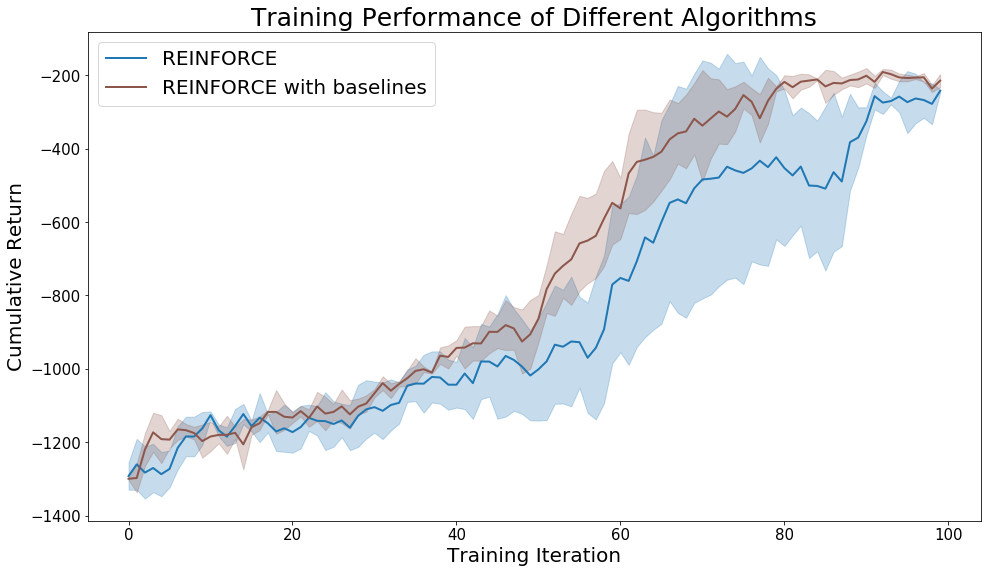

In [61]:
# collect saved results
import numpy as np
r1 = np.genfromtxt("InvertedPendulum_results_R.csv", delimiter=",")
r2 = np.genfromtxt("InvertedPendulum_results_Rb.csv", delimiter=",")
all_results = [r1, r2]
labels = ["REINFORCE", "REINFORCE with baselines"]

# plot the results
%matplotlib inline
from hw3_utils import plot_results
fig = plot_results(all_results, labels)

# Question 3: Actor-Critic Algorithms

The actor-critic algorithm presented in class is a natural extension to the REINFORCE algorithm with state-dependent baselines that you implemented in section 2.b. Given that the baseline we used in that problem is exactly the value function (i.e. the estimate of expected future returns from a start state), the $b_\phi (s_t)$ can simply be substituted with a $V_\phi^\pi(s_t)$ term and the gradient is then:

\begin{equation}
\nabla_\theta J (\theta) = \frac{1}{N} \sum_{i=0}^{N} \sum_{t=0}^{T} \nabla_\theta \log \pi_\theta (a_{it} | s_{it}) \bigg( \sum_{t'=t}^T \gamma^{t'-t}r_i(t') - V_\phi^\pi(s_{it}) \bigg)
\end{equation}


Moreover, estimated the expected return from a state as the reward at that state plus the estimate from the value function at the next state, the policy gradient for the actor-critic method is defined as:

\begin{equation}
\nabla_\theta J (\theta) = \frac{1}{N} \sum_{i=0}^{N} \sum_{t=0}^{T} \nabla_\theta \log \pi_\theta (a_{it} | s_{it}) \bigg( r_i(t) + \gamma (1-d_{it}) V_\phi^\pi(s_{i,t+1}) - V_\phi^\pi(s_{it})\bigg)
\end{equation}


Moreover, to update this value function estimate, we will now use our previous estimate of the value function, and the loss associated with it is then:

\begin{equation}
L_\phi = || V_\phi^\pi(s_t) - \big(r(t) + \gamma (1-d) V_\phi^\pi(s_{t+1}) \big) ||^2
\end{equation}

In the below cell, we modify the REINFORCE_baseline algorithm to support the actor-critic method mentioned above. Fill in the missing components (note that some of these components simply need to be copied over from the previous question).

In [5]:
class ActorCritic(REINFORCE_baseline):

    def train(self,
              num_iterations=100,
              steps_per_iteration=1000,
              learning_rate=0.001,
              gamma=0.95,
              **kwargs):
        """Perform the REINFORE with baselines training operation.

        Parameters
        ----------
        num_iterations : int
            number of training iterations
        steps_per_iteration : int
            number of individual samples collected every training
            iteration
        learning_rate : float
            optimizer learning rate
        gamma : float
            discount rate
        kwargs : dict
            additional arguments, containing:
            - "num_value_estimates": blank
            - "num_train_steps_per_estimate: blank

        Returns
        -------
        list of float
            average return per iteration
        """        
        return super().train(num_iterations=num_iterations,
                             steps_per_iteration=steps_per_iteration,
                             learning_rate=learning_rate,
                             gamma=gamma,
                             **kwargs)

    def compute_expected_return(self, samples):
        """Compute the expected return from a given starting state.

        This is done by using the reward-to-go method.

        Parameters
        ----------
        samples : list of dict
            trajectory information that was obtained while collecting 
            during this training iteration

        Returns
        -------
        list of float, or np.ndarray
            expected returns for each step in each trajectory
        """
        # rewards from the trajectories
        rewards = np.concatenate([s["reward"] for s in samples])
        # states from the trajectories
        states = np.concatenate([s["state"] for s in samples])
        # next states from the trajectories
        next_states = np.concatenate([s["next_state"] for s in samples])
        # done masks from the trajectories
        done = np.concatenate([s["done"] for s in samples])

        ##############################################################
        # Compute the expected returns.                              #
        #                                                            #
        # For this, we will assume that the expected return starting #
        # from the next state is the estimate of the return by our   #
        # baseline in section 2.b (i.e. self.v_s). Denoting this     #
        # function as V, and continuing to use the baseline          #
        # subtraction approach for reducing variance, the advantage  #
        # is expressed as:                                           #
        #                                                            #
        #     adv = r_t + gamma * (1 - done_t) * V(s_{t+1})          #
        #                                                            #
        # where t is the current time index.                         #
        #                                                            #
        # Note: Compute these values explicity (do not return        #
        # tensorflow objects).                                       #
        ##############################################################
        V = self.sess.run(self.v_s, feed_dict={self.s_t_ph: next_states})
        v_s = rewards + self.gamma * (1 - done) * V
        return v_s

    def call_updates(self,
                     log_likelihoods,
                     samples,
                     v_s,
                     **kwargs):
        """Apply the gradient update methods in a tensorflow session.

        This will now also include applying the gradients to the parameters 
        of the baseline.

        Parameters
        ----------
        log_likelihoods: tf.Operation
            the symbolic expression you created to estimate the log 
            likelihood of a set of actions
        states : list of list of np.ndarray
            a list of N trajectories, with each trajectory contain T 
            state values (one for each step in the trajectory)
        actions : list of list of np.ndarray
            a list of N trajectories, with each trajectory contain T 
            actions values (one for each step in the trajectory)
        v_s : list of float, or np.ndarray
            the estimated expected returns from your
            `compute_expected_return` function 
        kwargs : dict
            additional arguments (used in question 3)
        """
        # some variables for actor-critic (see the docstring in the 
        # train method)
        num_value_estimates = kwargs["num_value_estimates"]
        num_train_steps_per_estimate = kwargs["num_train_steps_per_estimate"]

        # concatenate the rewards
        rewards = np.concatenate([s["reward"] for s in samples])

        # concatenate the states
        states = np.concatenate([s["state"] for s in samples])

        # concatenate the next states
        next_states = np.concatenate([s["next_state"] for s in samples])

        # concatenate the actions
        actions = np.concatenate([s["action"] for s in samples])

        # concatenate the done masks
        dones = np.concatenate([s["done"] for s in samples])

        #################################################################
        # Call the policy update method as you had done in question 2.b #
        #################################################################
        baseline_val = self.sess.run(self.v_s, feed_dict={self.s_t_ph: states})
        advantages = v_s - baseline_val
        
        self.sess.run(self.opt, feed_dict={self.s_t_ph: states, self.a_t_ph: actions,
                                          self.rew_ph: advantages})  ### FILL IN ###

        ##############################################################
        # Use the bootstrapped estimates of the expected return to   #
        # modify the parameters of your critic self.v_s.             #
        #                                                            #
        # In order to do so, first use your current parametrization  #
        # of the value function to estimate the expected future      #
        # return. Then, for a number of steps, update the parameters #
        # of your value function based on the loss described at the  #
        # start of this problem.                                     #
        ##############################################################
        for _ in range(num_value_estimates):
            target = rewards + self.gamma * (1-dones) * self.sess.run(self.v_s, 
                                                                      feed_dict={self.s_t_ph: next_states})
            for _ in range(num_train_steps_per_estimate):
                self.sess.run(self.opt_baseline,
                              feed_dict={self.rew_ph: target,
                                         self.s_t_ph: states})

When you are ready, test your actor-critic algorithm on the *Pendulum-v0* environment in the cell below.

**Note**: Your best policy should get a max return of a bit over -150.

In [71]:
# set this number as 1 for testing your algorithm, and 3 for plotting
NUM_RUNS = 3

# ===========================================================================
# Do not modify below here
# ===========================================================================

# we will test the algorithms on the InvertedPendulum-v2 gym environment
import gym
env = gym.make("Pendulum-v0")

# train on the Actor Critic algorithm
import numpy as np
r = []
for i in range(NUM_RUNS):
    print("\n==== Training Run {} ====".format(i))
    alg = ActorCritic(env, stochastic=True)
    res = alg.train(learning_rate=0.01, gamma=0.95, steps_per_iteration=15000,
                    num_value_estimates=10, num_train_steps_per_estimate=10)
    r.append(np.array(res))
    alg = None

# save results
np.savetxt("InvertedPendulum_results_AC.csv", np.array(r), delimiter=",")

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.

==== Training Run 0 ====
Iteration 0 return: -1264.6235312372266
Iteration 1 return: -1346.03849539582
Iteration 2 return: -1362.5233359097285
Iteration 3 return: -1400.1139671798796
Iteration 4 return: -1362.8550851262112
Iteration 5 return: -1299.7298299519468
Iteration 6 return: -1306.551668669867
Iteration 7 return: -1283.3793859235477
Iteration 8 return: -1206.7293676850975
Iteration 9 return: -1142.61440891485
Iteration 10 return: -1088.2046557055723
Iteration 11 return: -1163.9120598907987
Iteration 12 return: -1177.605629825516
Iteration 13 return: -1185.835219425192
Iteration 14 return: -1145.3272758492828
Iteration 15 return: -1157.0626127216653
Iteration 16 return: -1165.0565935543443
Iteration 17 return: -1206.8071065244917
Iteration 18 return: -1175.3295005437017
Iteration 19 r

Iteration 96 return: -191.2370826905376
Iteration 97 return: -178.65784867112836
Iteration 98 return: -164.1328396535913
Iteration 99 return: -185.10560586149495

==== Training Run 2 ====
Iteration 0 return: -1274.0091667252966
Iteration 1 return: -1436.6119800289223
Iteration 2 return: -1537.3647072519113
Iteration 3 return: -1520.0148114209126
Iteration 4 return: -1444.2092200504553
Iteration 5 return: -1313.3460080906377
Iteration 6 return: -1270.8314877521557
Iteration 7 return: -1277.369064292498
Iteration 8 return: -1234.3934283463486
Iteration 9 return: -1183.4075369435518
Iteration 10 return: -1150.6558820685743
Iteration 11 return: -1152.662397112955
Iteration 12 return: -1173.7773977419733
Iteration 13 return: -1139.878554857918
Iteration 14 return: -1134.7526405903852
Iteration 15 return: -1123.8804946052842
Iteration 16 return: -1201.4902854649008
Iteration 17 return: -1244.6012389829755
Iteration 18 return: -1131.7239714035827
Iteration 19 return: -1073.0268612224345
Itera

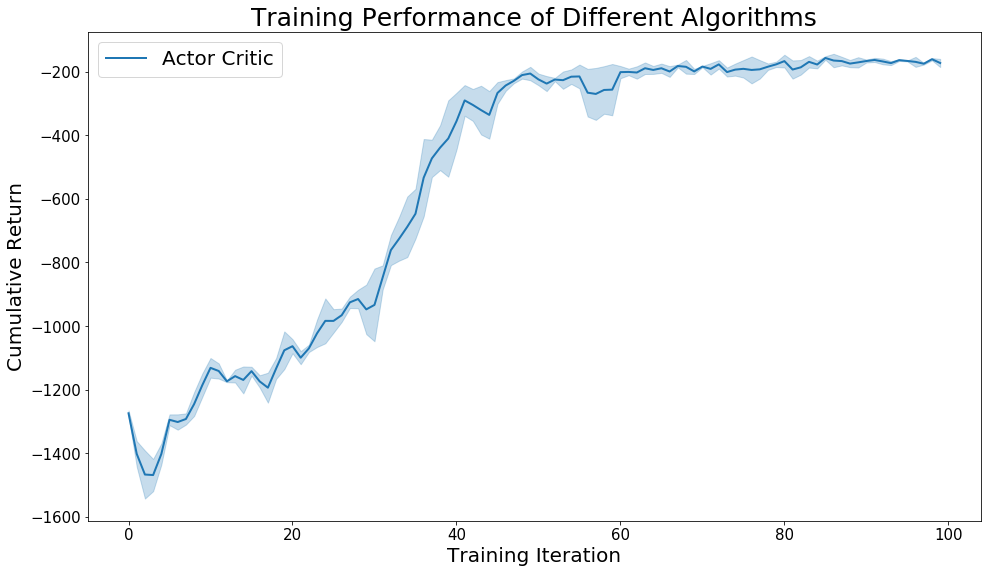

In [72]:
# collect saved results
import numpy as np
r = np.genfromtxt("InvertedPendulum_results_AC.csv", delimiter=",")
all_results = [r]
labels = ["Actor Critic"]

# plot the results
%matplotlib inline
from hw3_utils import plot_results
fig = plot_results(all_results, labels)

# Question 4: Learning "Stabilizing the Ring" Strategies

In questions 2 and 3, we developed a few algorithms that can be used to solve continuous control problems. We now attempt to use these algorithms to solve a widely studied problem, and one that has been frequently referenced in class as well as previous homeworks: stabilizing traffic in a ring road.

### a. Designing an environment

We begin by designing an MDP that is representative of our problem. Using the Flow computational framework, this can be done by creating an environment object, similar to the one used to trained an optimal traffic light policy in the previous assignment.

In the below cell, design an environment than can be used to develop a controller that can dissipate the formation of stop-and-go waves in a ring road. In order to do so, perform the following tasks:

1. Modify the `observation_space` and `get_state` methods so that your state is the speed of the RL vehicle, as well the RL vehicle's headway and the speed of the vehicle ahead of it (i.e. its leader). The headway values in the state space should be clipped from above by `self.headway_normalizer` term. Moreover, the speeds and headways in the state space should be divided by the `self.speed_normalizer` and `self.headway_noramlizer` terms, respectively.
2. Modify the `action_space` and `_apply_rl_actions` methods so that your policy's actions are converted to desired accelerations by the RL vehicle in the environment. The actions as defined in the `action_space` method should *not* be bounded.

**Hint**:

- For a review of creating custom environments in flow, please see the following [tutorial](https://github.com/flow-project/flow/blob/master/tutorials/tutorial06_environments.ipynb).
- Individual vehicle state information can be collected from the Vehicles class within an environmnet (called by `self.vehicles`). Refer to [this file](https://github.com/flow-project/flow/blob/master/flow/core/vehicles.py) for what sort of information can be collected. The same could be done for scenario/network information using the variable `self.scenario`, which the associated get methods available [here](https://github.com/flow-project/flow/blob/master/flow/scenarios/base_scenario.py).

In [10]:
from flow.envs import Env   # base environment class
from gym.spaces import Box  # used to define configuration of the state/action spaces
import numpy as np


class StabilizingTheRingEnv(Env):
    """Environment used to train ring stabilizing behavior.

    States
        The states are the speeds and headways of all vehicles.

    Actions
        The actions are an acceleration for each automated vehicle.

    Rewards
        The reward function rewards high average speeds from all vehicles in
        the network, and penalizes accelerations by the rl vehicle.

    Termination
        The rollout is terminate if the time horizon is met or if two 
        vehicles collide into one another.
    """
    def __init__(self, env_params, sumo_params, scenario):
        super().__init__(env_params, sumo_params, scenario)

        # constant to be divided from all speed values in the state space
        self.speed_normalizer = 30

        # constant to be divided from all headways in the state space
        self.headway_normalizer = 50
    
    @property
    def action_space(self):
        ##############################################################
        # specify dimensions and properties of the action space here #
        ##############################################################
        num_actions = self.vehicles.num_rl_vehicles

        return Box(
            low=0,
            high=float("inf"),
            shape=(num_actions,),
            dtype=np.float32)

    @property
    def observation_space(self):
        #############################################################
        # specify dimensions and properties of the state space here #
        #############################################################
        return Box(
            low=0,
            high=float("inf"),
            shape=(3*self.vehicles.num_vehicles,),
            dtype=np.float32)

    def get_state(self, **kwargs):
        ####################################
        # specify desired state space here #
        ####################################
        ids = self.vehicles.get_ids()
        vel = [self.vehicles.get_speed(veh_id) for veh_id in ids]
        headway = [self.vehicles.get_headway(veh_id) for veh_id in ids]
        leaders_ids = [self.vehicles.get_leader(veh_id) for veh_id in ids]
        vel_leader = [self.vehicles.get_speed(veh_id) for veh_id in leaders_ids]
        
        headway = np.clip(headway, a_min = 0, a_max = self.headway_normalizer)
        headway = np.divide(headway, self.headway_normalizer)
        
        vel = np.divide(vel, self.speed_normalizer)
        vel_leader = np.divide(vel_leader, self.speed_normalizer)
        
        return np.concatenate((vel, headway, vel_leader))

    def _apply_rl_actions(self, rl_actions):
        #####################################
        # specify desired action space here #
        #####################################
        rl_ids = self.vehicles.get_rl_ids()
        self.apply_acceleration(rl_ids, rl_actions)

    def compute_reward(self, state, rl_actions, **kwargs):
        # in the warmup steps
        if rl_actions is None:
            return 0

        vel = np.array([
            self.vehicles.get_speed(veh_id)
            for veh_id in self.vehicles.get_ids()
        ])

        if any(vel < -100) or kwargs["fail"]:
            return 0.

        # reward average velocity
        eta_2 = 4.
        reward = eta_2 * np.mean(vel) / 20

        # punish accelerations (should lead to reduced stop-and-go waves)
        eta = 8
        rl_actions = np.array(rl_actions)
        accel_threshold = 0

        if np.mean(np.abs(rl_actions)) > accel_threshold:
            reward += eta * (accel_threshold - np.mean(np.abs(rl_actions)))

        return float(reward)

### b. Training and testing

Once your environment is ready, you can train your environment by running the scripts below. Each cell is responsible for running a different algorithm, and will save the data and model from the most recent run, so feel free to play around with the hyperparameters of each algorithm independently. After you have trained everything, be sure to plot the training curves from all experiments by executing the last cell in the group.

**Note**: Your best policy should get a max return greater than 300.

In [11]:
### creating the gym environment
from hw3_utils import get_params, HORIZON

sumo_params, env_params, scenario = get_params()

env = StabilizingTheRingEnv(env_params=env_params, 
                            sumo_params=sumo_params, 
                            scenario=scenario)
env._max_episode_steps = HORIZON

/Users/barryfan/flow/flow/core/params.py:89: PendingDeprecationWarning: sumo_params will be deprecated in a future release, use render instead.
  PendingDeprecationWarning


In [112]:
### training on REINFORCE
import numpy as np
alg = REINFORCE(env, stochastic=True)

# feel free to modify the hyperparameters
cum_rewards = alg.train(learning_rate=0.1, gamma=0.99,
                        steps_per_iteration=3000, num_iterations=300)

alg.save_checkpoint("REINFORCE.ckpt")
np.savetxt("REINFORCE.csv", cum_rewards, delimiter=",")

Iteration 0 return: -20453.088145497837
Iteration 1 return: -59380.442021328956
Iteration 2 return: -17431.70872560062
Iteration 3 return: -15783.34184441017
Iteration 4 return: -18037.391692951118
Iteration 5 return: -32055.70682295179
Iteration 6 return: -26927.3370269062
Iteration 7 return: -33534.22549474798
Iteration 8 return: -43842.38156162202
Iteration 9 return: -60103.723974622786
Iteration 10 return: -175891.74021492526
Iteration 11 return: -55029.72281318065
Iteration 12 return: -41567.47551031783
Iteration 13 return: -35167.6484169513
Iteration 14 return: -26672.509613577742
Iteration 15 return: -21852.602470100275
Iteration 16 return: -18603.768339163566
Iteration 17 return: -16993.054101598216
Iteration 18 return: -15770.245256995782
Iteration 19 return: -15229.536127502564
Iteration 20 return: -14523.665299168613
Iteration 21 return: -14337.871255538921
Iteration 22 return: -14386.001392550766
Iteration 23 return: -14246.170291151793
Iteration 24 return: -13834.787151751

Iteration 201 return: -2514.9473894956827
Iteration 202 return: -2556.9017040488834
Iteration 203 return: -2448.437604806906
Iteration 204 return: -2458.4815408808645
Iteration 205 return: -2521.8534962512786
Iteration 206 return: -2446.3965851440116
Iteration 207 return: -2366.0091017434606
Iteration 208 return: -2387.148116373166
Iteration 209 return: -2365.2207899072237
Iteration 210 return: -2431.9379460507425
Iteration 211 return: -2420.976818263928
Iteration 212 return: -2356.9178469824255
Iteration 213 return: -2326.674394726382
Iteration 214 return: -2321.9993717898706
Iteration 215 return: -2429.370927550728
Iteration 216 return: -2300.9495430357056
Iteration 217 return: -2262.752551585814
Iteration 218 return: -2242.4489774130634
Iteration 219 return: -2263.01239402618
Iteration 220 return: -2271.2640564008543
Iteration 221 return: -2276.954372404056
Iteration 222 return: -2257.684324111353
Iteration 223 return: -2188.61479061305
Iteration 224 return: -2161.8052795262483
Iter

In [113]:
### training on REINFORCE with a baseline
import numpy as np
alg = REINFORCE_baseline(env, stochastic=True)

# feel free to modify the hyperparameters
cum_rewards = alg.train(learning_rate=0.1, gamma=0.99,
                        steps_per_iteration=3000, num_iterations=300)

alg.save_checkpoint("REINFORCE_baseline.ckpt")
np.savetxt("REINFORCE_baseline.csv", cum_rewards, delimiter=",")

Iteration 0 return: -20453.085803490772
Iteration 1 return: -57898.29303825926
Iteration 2 return: -18092.001832951908
Iteration 3 return: -15767.24449495296
Iteration 4 return: -16656.621609758062
Iteration 5 return: -26530.380880340934
Iteration 6 return: -24618.002171626198
Iteration 7 return: -33180.40001095552
Iteration 8 return: -42397.04926580959
Iteration 9 return: -38572.52329727402
Iteration 10 return: -78091.64225140959
Iteration 11 return: -95361.76842002943
Iteration 12 return: -69025.02452399582
Iteration 13 return: -43407.76118324255
Iteration 14 return: -41185.68153439043
Iteration 15 return: -39315.34900860768
Iteration 16 return: -36972.85303289862
Iteration 17 return: -33056.47134302277
Iteration 18 return: -28573.05710922554
Iteration 19 return: -24633.280207168777
Iteration 20 return: -21471.98652702923
Iteration 21 return: -19077.459821090335
Iteration 22 return: -17380.08355066384
Iteration 23 return: -16203.648312647361
Iteration 24 return: -15133.855855359929
I

Iteration 201 return: -1340.9196832370508
Iteration 202 return: -1376.2045259698352
Iteration 203 return: -1311.700760609885
Iteration 204 return: -1304.0333244666363
Iteration 205 return: -1331.7111635938345
Iteration 206 return: -1291.7973840520717
Iteration 207 return: -1250.1773915121885
Iteration 208 return: -1280.3696721667075
Iteration 209 return: -1244.1034636839904
Iteration 210 return: -1280.1496855561563
Iteration 211 return: -1249.841388709683
Iteration 212 return: -1199.0169356407423
Iteration 213 return: -1193.313622629008
Iteration 214 return: -1182.0788687394815
Iteration 215 return: -1248.543270736991
Iteration 216 return: -1142.8772491629934
Iteration 217 return: -1121.4386788008123
Iteration 218 return: -1116.121806152878
Iteration 219 return: -1130.5669382968845
Iteration 220 return: -1120.6758466699393
Iteration 221 return: -1126.7413984664163
Iteration 222 return: -1096.6855791645066
Iteration 223 return: -1074.7274018088065
Iteration 224 return: -1069.05270525054

In [132]:
### training on Actor Critic
import numpy as np
alg = ActorCritic(env, stochastic=True)

# feel free to modify the hyperparameters
cum_rewards = alg.train(learning_rate=0.1, gamma=0.99, 
                        steps_per_iteration=3000, num_iterations=217,
                        num_value_estimates=10, num_train_steps_per_estimate=10)

alg.save_checkpoint("ActorCritic.ckpt")
np.savetxt("ActorCritic.csv", cum_rewards, delimiter=",")

Iteration 0 return: -20453.088145497837
Iteration 1 return: -24136.198315038695
Iteration 2 return: -39584.30919327965
Iteration 3 return: -16894.683312681038
Iteration 4 return: -14025.366779956501
Iteration 5 return: -12683.578209112922
Iteration 6 return: -11677.189443249023
Iteration 7 return: -10348.441592666553
Iteration 8 return: -9498.58525602322
Iteration 9 return: -8567.615441127564
Iteration 10 return: -7771.2979004258805
Iteration 11 return: -7054.799584744935
Iteration 12 return: -6696.692917637527
Iteration 13 return: -6116.55804123728
Iteration 14 return: -5531.4639365897165
Iteration 15 return: -4838.853192058741
Iteration 16 return: -4437.805693631974
Iteration 17 return: -4246.142810300109
Iteration 18 return: -3770.029833021341
Iteration 19 return: -3469.4232060479117
Iteration 20 return: -3148.5636925595463
Iteration 21 return: -2878.6697882923618
Iteration 22 return: -2742.1827115343185
Iteration 23 return: -2582.72080860383
Iteration 24 return: -2272.0764484521715

Iteration 204 return: 384.9936490354012
Iteration 205 return: 367.467763940178
Iteration 206 return: 397.4393871640059
Iteration 207 return: 371.95368255587164
Iteration 208 return: 374.7680496454559
Iteration 209 return: 406.1816544702742
Iteration 210 return: 373.06204514017736
Iteration 211 return: 349.1019850291632
Iteration 212 return: 395.16441854217555
Iteration 213 return: 405.8974200611192
Iteration 214 return: 353.8922458320594
Iteration 215 return: 359.56432140379184
Iteration 216 return: 409.59941477223765


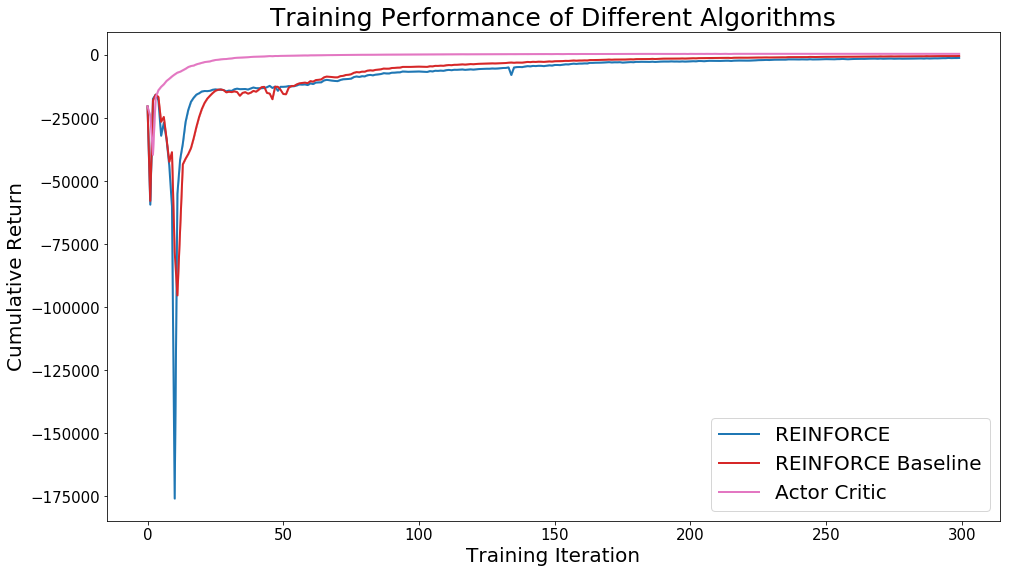

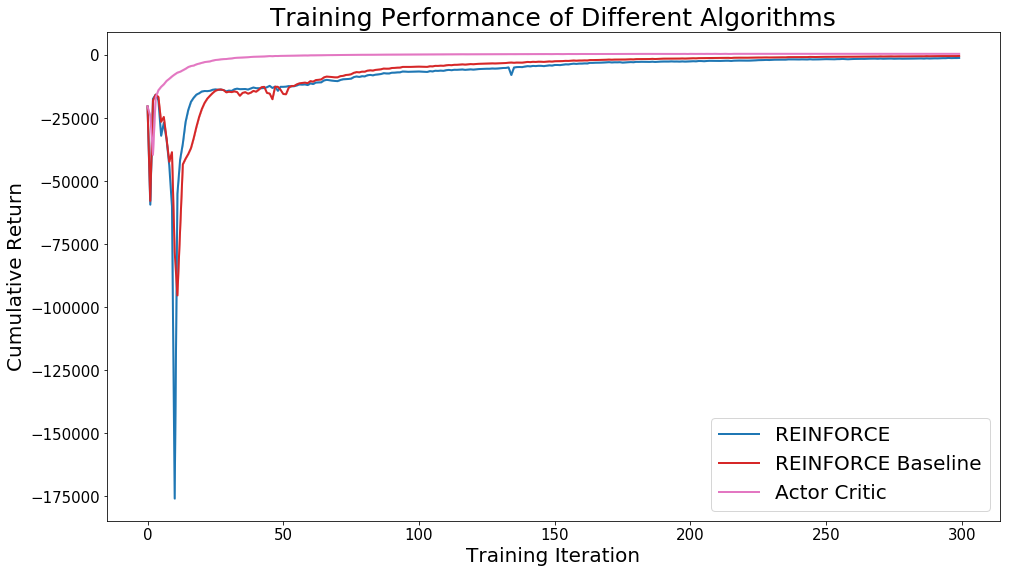

In [145]:
### plotting results
import numpy as np
from hw3_utils import plot_results

res_REINFORCE = np.array([np.genfromtxt("REINFORCE.csv")])
res_REINFORCE_baseline = np.array([np.genfromtxt("REINFORCE_baseline.csv")])
res_Actor_Critic_1 = np.array([np.genfromtxt("ActorCritic.csv")])
res_Actor_Critic = np.zeros((1, 300))
res_Actor_Critic[0, 0:res_Actor_Critic_1.shape[1]] = res_Actor_Critic_1
res_Actor_Critic[0, res_Actor_Critic_1.shape[1]:300] = res_Actor_Critic_1[0, res_Actor_Critic_1.shape[1]-1]
all_results = np.array([res_REINFORCE, res_REINFORCE_baseline, res_Actor_Critic])
labels = ["REINFORCE", "REINFORCE Baseline", "Actor Critic"]

plot_results(all_results, labels)

Finally, test that at least one of your algorithms has successfully managed to dissipate the formation of stop and go waves in the ring road network. In order to do so, specify the policy that performed the best from your implementations above and rerun it on the network in the cell below. If your training algorithm was successful, the average speed of vehicles should remain near the higher dotted line in the generated figure below.

/Users/barryfan/flow/flow/core/params.py:89: PendingDeprecationWarning: sumo_params will be deprecated in a future release, use render instead.
  PendingDeprecationWarning


INFO:tensorflow:Restoring parameters from /Users/barryfan/Documents/Berkeley/2018FA/EE290O/EE290O-master/homeworks/homework3/ActorCritic.ckpt


INFO:tensorflow:Restoring parameters from /Users/barryfan/Documents/Berkeley/2018FA/EE290O/EE290O-master/homeworks/homework3/ActorCritic.ckpt


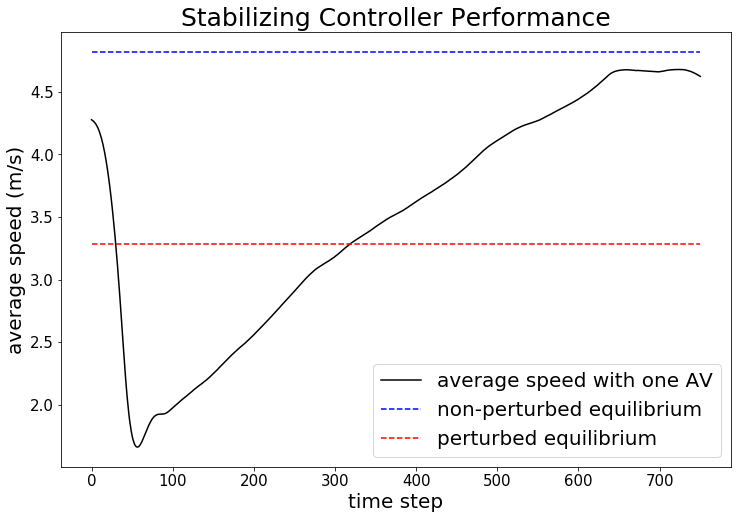

In [150]:
###########################################################
# Specify the algorithm you would like to visualize here. #
#                                                         #
# Choose one of:                                          #
# - "REINFORCE"                                           #
# - "REINFORCE_baseline"                                  #
# - "ActorCritic"                                         #
###########################################################
alg_name = "ActorCritic"

# ===========================================================================
# Do not modify below here
# ===========================================================================

import matplotlib.pyplot as plt
import numpy as np
from hw3_utils import get_params, HORIZON

assert alg_name in ["REINFORCE", "REINFORCE_baseline", "ActorCritic"]

# modify the reward function of the environment to output average speeds:
class TestEnvironment(StabilizingTheRingEnv):
    def compute_reward(self, state, rl_actions, **kwargs):
        return np.mean(self.vehicles.get_speed(self.vehicles.get_ids()))

# create the gym environment
sumo_params, env_params, scenario = get_params(render=True)
env = TestEnvironment(env_params=env_params, 
                      sumo_params=sumo_params, 
                      scenario=scenario)
env._max_episode_steps = HORIZON

# run the environment for one rollout with the trained policy
alg = DirectPolicyAlgorithm(env, stochastic=True)
alg.load_checkpoint(alg_name + ".ckpt")
samples = alg.rollout()

# plot the results from that rollout
avg_speeds = samples["reward"]

plt.figure(figsize=(12,8))
plt.title("Stabilizing Controller Performance", fontsize=25)
plt.xlabel("time step", fontsize=20)
plt.ylabel("average speed (m/s)", fontsize=20)
plt.plot(avg_speeds, c='k', label="average speed with one AV")
plt.plot([4.82] * len(avg_speeds), '--', c='b', label="non-perturbed equilibrium")
plt.plot([3.28] * len(avg_speeds), '--', c='r', label="perturbed equilibrium")
plt.legend(fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

# Question 5: Effect of Hyperparameters (BONUS)

Explore the effect of one or more hyperparamters (e.g. depth or width of your neural network, learning rate, etc...) on the training performance of one of your algorithms on the above task. Plot the training results for each choice hyperparameter in the cell below.

One of the hyperparameters that I have already changed is the number of iterations of Actor Critic. If I run it for 300 iterations, the return value goes into an abyss at about iteration 220. Perhaps the gradient exploded since this happened really fast. After happening twice, I limited it to 217 iterations (the last stable point) and the result looks good.

In order to mitigate this, I will try a smaller learning rate and see if the learning will stablize.

In [155]:
############################################
#### Perform hyperparameter search here ####
############################################
import numpy as np
alg = ActorCritic(env, stochastic=True)

# feel free to modify the hyperparameters
cum_rewards = alg.train(learning_rate=0.05, gamma=0.99, 
                        steps_per_iteration=3000, num_iterations=300,
                        num_value_estimates=10, num_train_steps_per_estimate=10)

alg.save_checkpoint("ActorCritic_2.ckpt")
np.savetxt("ActorCritic_2.csv", cum_rewards, delimiter=",")

Iteration 0 return: -20453.088145497837
Iteration 1 return: -20373.17151832208
Iteration 2 return: -20658.04620042839
Iteration 3 return: -17660.883280654438
Iteration 4 return: -16751.781289043138
Iteration 5 return: -15855.574350992509
Iteration 6 return: -15195.603341984446
Iteration 7 return: -13894.915079128346
Iteration 8 return: -13629.31094802919
Iteration 9 return: -12814.591156229377
Iteration 10 return: -12288.609911591106
Iteration 11 return: -11603.680133578076
Iteration 12 return: -11265.526140476752
Iteration 13 return: -10987.929594735848
Iteration 14 return: -10407.732098702108
Iteration 15 return: -9544.917984685744
Iteration 16 return: -9115.916075446934
Iteration 17 return: -8865.18620367904
Iteration 18 return: -8384.797789919976
Iteration 19 return: -8023.275829243008
Iteration 20 return: -7505.8674130818445
Iteration 21 return: -7237.536857675004
Iteration 22 return: -7046.031592441141
Iteration 23 return: -6739.169858763467
Iteration 24 return: -6293.92701535212

Iteration 201 return: 18.868041766640175
Iteration 202 return: 8.842376880342272
Iteration 203 return: 22.064352914650954
Iteration 204 return: 27.557757430280617
Iteration 205 return: 23.306984346694662
Iteration 206 return: 30.867106231307844
Iteration 207 return: 45.06228442971042
Iteration 208 return: 33.93398940171028
Iteration 209 return: 45.69647887349129
Iteration 210 return: 32.42345936135462
Iteration 211 return: 46.18898008632095
Iteration 212 return: 53.48967554522824
Iteration 213 return: 52.809806119457335
Iteration 214 return: 61.54404667446943
Iteration 215 return: 44.6497958944783
Iteration 216 return: 71.9353472487087
Iteration 217 return: 75.13471224215891
Iteration 218 return: 83.45315838792703
Iteration 219 return: 82.45749711593089
Iteration 220 return: 86.78329774356973
Iteration 221 return: 79.88775856144275
Iteration 222 return: 90.43934953917051
Iteration 223 return: 87.2012918233595
Iteration 224 return: 93.39848868716217
Iteration 225 return: 93.291047660830

/Users/barryfan/flow/flow/core/params.py:89: PendingDeprecationWarning: sumo_params will be deprecated in a future release, use render instead.
  PendingDeprecationWarning


Could not connect to TraCI server at localhost:64779 [Errno 61] Connection refused
 Retrying in 1 seconds
Could not connect to TraCI server at localhost:64779 [Errno 61] Connection refused
 Retrying in 2 seconds
Could not connect to TraCI server at localhost:64779 [Errno 61] Connection refused
 Retrying in 3 seconds
INFO:tensorflow:Restoring parameters from /Users/barryfan/Documents/Berkeley/2018FA/EE290O/EE290O-master/homeworks/homework3/ActorCritic_2.ckpt


INFO:tensorflow:Restoring parameters from /Users/barryfan/Documents/Berkeley/2018FA/EE290O/EE290O-master/homeworks/homework3/ActorCritic_2.ckpt


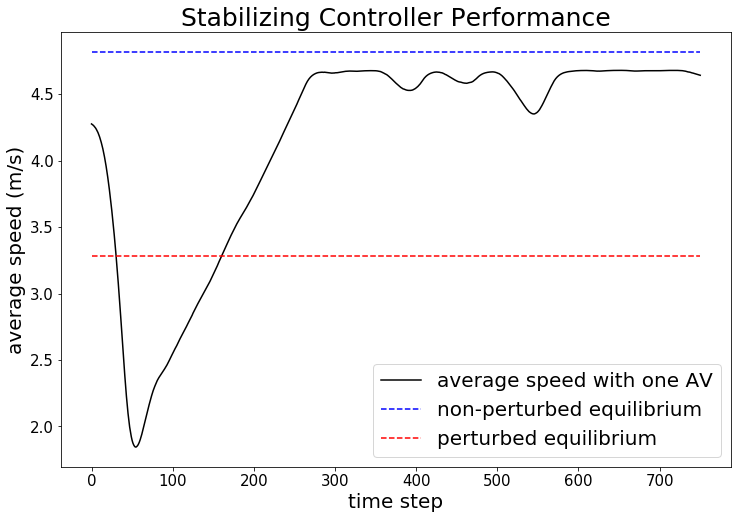

In [157]:
alg_name = "ActorCritic_2"

# ===========================================================================
# Do not modify below here
# ===========================================================================

import matplotlib.pyplot as plt
import numpy as np
from hw3_utils import get_params, HORIZON

# modify the reward function of the environment to output average speeds:
class TestEnvironment(StabilizingTheRingEnv):
    def compute_reward(self, state, rl_actions, **kwargs):
        return np.mean(self.vehicles.get_speed(self.vehicles.get_ids()))

# create the gym environment
sumo_params, env_params, scenario = get_params(render=True)
env = TestEnvironment(env_params=env_params, 
                      sumo_params=sumo_params, 
                      scenario=scenario)
env._max_episode_steps = HORIZON

# run the environment for one rollout with the trained policy
alg = DirectPolicyAlgorithm(env, stochastic=True)
alg.load_checkpoint(alg_name + ".ckpt")
samples = alg.rollout()

# plot the results from that rollout
avg_speeds = samples["reward"]

plt.figure(figsize=(12,8))
plt.title("Stabilizing Controller Performance", fontsize=25)
plt.xlabel("time step", fontsize=20)
plt.ylabel("average speed (m/s)", fontsize=20)
plt.plot(avg_speeds, c='k', label="average speed with one AV")
plt.plot([4.82] * len(avg_speeds), '--', c='b', label="non-perturbed equilibrium")
plt.plot([3.28] * len(avg_speeds), '--', c='r', label="perturbed equilibrium")
plt.legend(fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

A smaller learning rate does stablize learning a little bit. We can see that, although the final return value is not as good as 400, the new controller almost works as good as the previous one. And it stablizes traffic faster than the first one.

Now let's test larger discount.

In [14]:
############################################
#### Perform hyperparameter search here ####
############################################
import numpy as np
alg = ActorCritic(env, stochastic=True)

# feel free to modify the hyperparameters
cum_rewards = alg.train(learning_rate=0.05, gamma=0.9, 
                        steps_per_iteration=3000, num_iterations=300,
                        num_value_estimates=10, num_train_steps_per_estimate=10)

alg.save_checkpoint("ActorCritic_3.ckpt")
np.savetxt("ActorCritic_3.csv", cum_rewards, delimiter=",")

Iteration 0 return: -20453.094957241672
Iteration 1 return: -20382.618670379277
Iteration 2 return: -20568.1734604924
Iteration 3 return: -17639.66299106495
Iteration 4 return: -16747.504921282874
Iteration 5 return: -15853.578109499416
Iteration 6 return: -15204.207169054192
Iteration 7 return: -13899.16518739611
Iteration 8 return: -13631.316696379668
Iteration 9 return: -12819.202756532119
Iteration 10 return: -12237.183594135684
Iteration 11 return: -11590.345302321715
Iteration 12 return: -11242.65618382988
Iteration 13 return: -10986.29741230898
Iteration 14 return: -10416.446746799164
Iteration 15 return: -9548.77414425998
Iteration 16 return: -9108.59082571388
Iteration 17 return: -8864.1371405815
Iteration 18 return: -8407.75828228204
Iteration 19 return: -7999.627419441997
Iteration 20 return: -7502.263096146053
Iteration 21 return: -7238.96471404258
Iteration 22 return: -7047.356955463154
Iteration 23 return: -6735.505814023665
Iteration 24 return: -6285.535699681786
Iterati

Iteration 201 return: 39.320790076398225
Iteration 202 return: 28.068529120714174
Iteration 203 return: 41.9401804199515
Iteration 204 return: 51.39215421033077
Iteration 205 return: 50.832416915262
Iteration 206 return: 57.747655834922625
Iteration 207 return: 69.52200676809298
Iteration 208 return: 55.298525805046665
Iteration 209 return: 63.48490970955754
Iteration 210 return: 52.88027815082933
Iteration 211 return: 69.21466525777942
Iteration 212 return: 77.26956584073923
Iteration 213 return: 78.36861023287565
Iteration 214 return: 83.13578659950144
Iteration 215 return: 63.6664324829253
Iteration 216 return: 87.08791721173293
Iteration 217 return: 87.7573633936704
Iteration 218 return: 103.38014890670456
Iteration 219 return: 104.62116380664702
Iteration 220 return: 110.19267941424187
Iteration 221 return: 100.18787191100273
Iteration 222 return: 106.93088463672757
Iteration 223 return: 104.32972448408282
Iteration 224 return: 108.18465855661998
Iteration 225 return: 107.73354792

/Users/barryfan/flow/flow/core/params.py:89: PendingDeprecationWarning: sumo_params will be deprecated in a future release, use render instead.
  PendingDeprecationWarning


Could not connect to TraCI server at localhost:52618 [Errno 61] Connection refused
 Retrying in 1 seconds
Could not connect to TraCI server at localhost:52618 [Errno 61] Connection refused
 Retrying in 2 seconds
Could not connect to TraCI server at localhost:52618 [Errno 61] Connection refused
 Retrying in 3 seconds
INFO:tensorflow:Restoring parameters from /Users/barryfan/Documents/Berkeley/2018FA/EE290O/EE290O-master/homeworks/homework3/ActorCritic_3.ckpt


INFO:tensorflow:Restoring parameters from /Users/barryfan/Documents/Berkeley/2018FA/EE290O/EE290O-master/homeworks/homework3/ActorCritic_3.ckpt


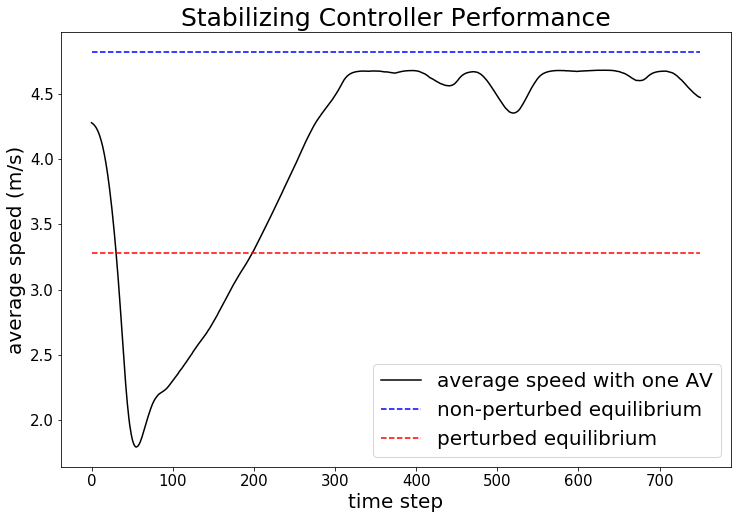

In [15]:
alg_name = "ActorCritic_3"

# ===========================================================================
# Do not modify below here
# ===========================================================================

import matplotlib.pyplot as plt
import numpy as np
from hw3_utils import get_params, HORIZON

# modify the reward function of the environment to output average speeds:
class TestEnvironment(StabilizingTheRingEnv):
    def compute_reward(self, state, rl_actions, **kwargs):
        return np.mean(self.vehicles.get_speed(self.vehicles.get_ids()))

# create the gym environment
sumo_params, env_params, scenario = get_params(render=True)
env = TestEnvironment(env_params=env_params, 
                      sumo_params=sumo_params, 
                      scenario=scenario)
env._max_episode_steps = HORIZON

# run the environment for one rollout with the trained policy
alg = DirectPolicyAlgorithm(env, stochastic=True)
alg.load_checkpoint(alg_name + ".ckpt")
samples = alg.rollout()

# plot the results from that rollout
avg_speeds = samples["reward"]

plt.figure(figsize=(12,8))
plt.title("Stabilizing Controller Performance", fontsize=25)
plt.xlabel("time step", fontsize=20)
plt.ylabel("average speed (m/s)", fontsize=20)
plt.plot(avg_speeds, c='k', label="average speed with one AV")
plt.plot([4.82] * len(avg_speeds), '--', c='b', label="non-perturbed equilibrium")
plt.plot([3.28] * len(avg_speeds), '--', c='r', label="perturbed equilibrium")
plt.legend(fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

The result is about the same as the previous trial. Changing discount rate does not have a significant effect.